<a href="https://colab.research.google.com/github/bhaweshiitk/20.C51_project/blob/main/20_C51_Graduate_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
! pip install Bio
!pip install umap-learn
from Bio import SeqIO
import umap

In [2]:
# RNN, Hybrid RNN-CNN
# Linear regression, MLP, Random Forest
# Hyperparam tuning 
# Distance between train and test set

In [3]:
# Import data
! wget https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_annotations_v2.00.csv
! wget https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_database_v2.00.fasta

--2022-05-08 05:31:34--  https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_annotations_v2.00.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948917 (927K) [text/plain]
Saving to: ‘megares_modified_annotations_v2.00.csv.3’

megares_modified_an 100%[===================>] 926.68K  --.-KB/s    in 0.03s   

2022-05-08 05:31:34 (32.8 MB/s) - ‘megares_modified_annotations_v2.00.csv.3’ saved [948917/948917]

--2022-05-08 05:31:34--  https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_database_v2.00.fasta
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.10

In [4]:
# Process data
train_annotations = pd.read_csv("./megares_modified_annotations_v2.00.csv")
train_annotations.shape

(7868, 5)

In [5]:
train_annotations.head()

,header,type,class,mechanism,group
0,MEG_1|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
1,MEG_2|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
2,MEG_3|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
3,MEG_4|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
4,MEG_5|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S


In [6]:
train_annotations['Seq_name'] = train_annotations['header'].str.split('|').str[0:2].apply('|'.join)
train_annotations['mechanism'] = train_annotations['header'].str.split('|').str[3]

In [7]:
fasta_sequences = SeqIO.parse(open("./megares_modified_database_v2.00.fasta"),'fasta')
sequence_dict = {}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    name = "|".join((name.split("|", 2))[0:2])
    sequence_dict[name] = sequence
sequence_df = pd.DataFrame(sequence_dict.items(), columns=['Seq_name', 'Sequence'])
sequence_df.shape

(7868, 2)

In [8]:
sequence_df.head()

,Seq_name,Sequence
0,MEG_1|Drugs,AGAATTTGATCTTGGTTCAGATTGAACGCTGGCGGCGTGGATGAGG...
1,MEG_2|Drugs,AGGTAAGGAGGTGATCCAACCGCAGGTTCCCCTACGGTTACCTTGT...
2,MEG_3|Drugs,TTTTGTTTGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGC...
3,MEG_4|Drugs,AGAGATTGAACATAAGAGTTTGATCCTGGCTCAGATTGAACGCTGG...
4,MEG_5|Drugs,AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...


In [9]:
df = pd.merge(train_annotations[['Seq_name', 'type', 'class','mechanism','group']], 
              sequence_df, how = "inner", on = ["Seq_name"])
df.shape

(7868, 6)

In [10]:
df.head()

,Seq_name,type,class,mechanism,group,Sequence
0,MEG_1|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGAATTTGATCTTGGTTCAGATTGAACGCTGGCGGCGTGGATGAGG...
1,MEG_2|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGGTAAGGAGGTGATCCAACCGCAGGTTCCCCTACGGTTACCTTGT...
2,MEG_3|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,TTTTGTTTGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGC...
3,MEG_4|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGAGATTGAACATAAGAGTTTGATCCTGGCTCAGATTGAACGCTGG...
4,MEG_5|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...


In [11]:
df["class"].value_counts()

betalactams                                        3911
Aminoglycosides                                     773
Drug and biocide resistance                         363
Glycopeptides                                       299
Fluoroquinolones                                    296
Tetracyclines                                       294
MLS                                                 270
Multi-metal resistance                              226
Phenicol                                            145
Trimethoprim                                        135
Copper resistance                                   117
Multi-drug resistance                               113
Sulfonamides                                        103
Multi-biocide resistance                             98
Lipopeptides                                         95
Rifampin                                             70
Fosfomycin                                           62
Mercury resistance                              

In [12]:
df["mechanism"].value_counts()

Class_A_betalactamases                 1580
Class_C_betalactamases                  950
Class_D_betalactamases                  900
Class_B_betalactamases                  410
Aminoglycoside_N-acetyltransferases     359
                                       ... 
Tetracenomycin_MFS_efflux_pump            1
Tunicamycin_resistance_protein            1
Chromate_ABC_efflux_pump                  1
Biguanide_cation_efflux                   1
Sulfonamide_monooxygenase                 1
Name: mechanism, Length: 219, dtype: int64

In [13]:
label_1 = ['Aminoglycosides', 'betalactams', 'Glycopeptides', 'Tetracyclines', 'MLS', 'Fluoroquinolones', 'Trimethoprim',
           'Phenicol', 'Sulfonamides', 'Sulfonamides', 'Lipopeptides']

In [14]:
df['labels'] = df["class"]
df.loc[~df['labels'].isin(label_1),'labels'] = "other"

In [15]:
df.labels.value_counts()

betalactams         3911
other               1547
Aminoglycosides      773
Glycopeptides        299
Fluoroquinolones     296
Tetracyclines        294
MLS                  270
Phenicol             145
Trimethoprim         135
Sulfonamides         103
Lipopeptides          95
Name: labels, dtype: int64

In [16]:
X = df.Sequence.values
y = df.labels.values
print(X.shape, y.shape)
index_to_remove = []
for (i, seq) in enumerate(X):
  if set(seq.upper())!={"A", "T", "C", "G"}:
    index_to_remove.append(i)
index_to_remove
X = np.delete(X, index_to_remove, axis=0)
y = np.delete(y, index_to_remove, axis=0)
print(X.shape, y.shape)


(7868,) (7868,)
(7819,) (7819,)


In [17]:
code = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
label_code_1 = {"betalactams":0, "Aminoglycosides":1, "Glycopeptides":2, "Fluoroquinolones":3, "Tetracyclines":4, "MLS":5,
                 'Trimethoprim':6,'Phenicol':7,  'Sulfonamides':8, 'Lipopeptides':9,"other":10}


In [18]:

import torch.nn.functional as F

def encode(seq, label, labels_dict):
  label_int = labels_dict[label]
  enc_seq = [code[x] for x in seq.upper()]
  return [torch.LongTensor(enc_seq[0:2000]), torch.LongTensor([label_int]), len(enc_seq)]

class SequenceDataset(Dataset):
    def __init__(self, X, y, labels_dict):
        
        self.X = X 
        self.y = y 
        self.labels_dict =labels_dict
        self.len=len(self.X)      

    def __getitem__(self, index):
        # your implementation here: 
        X_elem, y_elem, length_seq = encode(self.X[index], self.y[index], labels_dict=self.labels_dict)
        return F.pad(X_elem, pad=(0, 2000 - len(X_elem))), y_elem

    def __len__(self):
        return self.len
    




In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 

In [20]:
train_data = SequenceDataset(X_train, y_train, labels_dict=label_code_1)
val_data = SequenceDataset(X_val, y_val, labels_dict=label_code_1)
test_data = SequenceDataset(X_test, y_test, labels_dict=label_code_1)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# fill in code here
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)# fill in code here
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)# fill in code here

In [21]:
class cnn1d(nn.Module):
    def __init__(self, label_count = len(label_code_1)):
        super(cnn1d, self).__init__()
        self.embedding = nn.Embedding(5, 2*label_count)
        self.conv1 = nn.Conv1d(2*label_count, 64, kernel_size = 3, padding='same')
        self.maxpool1 = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool2 = nn.MaxPool1d(kernel_size=5)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool3 = nn.MaxPool1d(kernel_size=5)
        self.dense = nn.Sequential(nn.Linear(1024, 256), 
                             nn.ReLU(), nn.Linear(256, 64),
                             nn.ReLU(), nn.Linear(64, label_count))

    def forward(self, x):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.embedding(x)
        # print(x.shape)
        # Apply pooling
        x = self.conv1(x.permute(0, 2, 1))
        # print(x.shape)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        # print(x.shape)
        # Flatten and convert to vectors
        # x = torch.flatten(x, 1)
        # x = self.fc1(x)
        # x = self.classifier(x)
        return x

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [23]:
model = cnn1d()
model = model.to(device)
# for data in train_loader:
#   model(data[0])


In [24]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3) 

In [25]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function to train on the entire dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization 
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    batch_loss = []
    model.train() # Set model to training mode 
    train_loss = 0 
    count = 0
    for batch in dataloader:    
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        
        # train your model on each batch here 
        y_pred = model(seq)
        loss = nn.functional.cross_entropy(y_pred, label.squeeze())# fill in loss here
        train_loss += loss*len(label)
        count += len(label)
        batch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/count
    return np.array(batch_loss).mean(), train_loss.detach().cpu().numpy()


def validate(model, dataloader, device):
    
    '''
    A function to validate on the validation dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    batch_loss = []
    model.eval() # Set model to evaluation mode 
    val_loss = 0
    count = 0
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = nn.functional.cross_entropy(y_pred, label.squeeze())# fill in loss here
            val_loss += loss*len(label)
            count += len(label)
            batch_loss.append(loss.item())
            # validate your model on each batch here 
        val_loss = val_loss/count     
    return np.array(batch_loss).mean(), val_loss.detach().cpu().numpy()  

In [26]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(6):
    
    # Compute train your model on training data
    epoch_loss, train_loss = train(model, train_dataloader, optimizer,  device=0)
    
    # Validate your on validation data 
    _, val_loss = validate(model, val_dataloader, device=0) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler records the validation loss 
    # scheduler.step(val_loss)
    
    print(epoch, train_loss, val_loss)

epoch train loss validation loss
0 1.1747968 0.8710439
1 0.7216225 0.58243376
2 0.48583105 0.42497075
3 0.33920375 0.5007283
4 0.24342205 0.38574055
5 0.16202304 0.3817208


In [28]:
pred_labels = []
true_labels = []
test_loss = 0
with torch.no_grad():
  model.eval()
  for batch in test_dataloader:
    seq, label = batch
    seq = seq.to(device)
    label = label.to(device)
    logits = model(seq)
    test_loss += nn.functional.cross_entropy(logits, label.squeeze())*len(label)
    preds = logits.max(1).indices
    true_labels.extend(list(label.squeeze().detach().cpu().numpy()))
    pred_labels.extend(list(preds.squeeze().detach().cpu().numpy()))
test_loss = test_loss/len(test_data)
test_acc = (np.array(true_labels) == np.array(pred_labels)).mean()
print("Test loss is {}".format(test_loss))
print("Test Acc is {}".format(test_acc))

Test loss is 0.3690156638622284
Test Acc is 0.8976982097186701


In [29]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(true_labels, pred_labels)
cmat

array([[725,   3,   1,   1,   0,   0,   0,   0,   0,   1,  16],
       [  5, 149,   2,   0,   0,   1,   0,   0,   0,   0,   9],
       [  1,   3,  37,   0,   0,   0,   0,   1,   0,   0,  10],
       [  0,   0,   0,  63,   1,   2,   0,   0,   0,   0,   6],
       [  1,   0,   0,   0,  47,   0,   0,   0,   0,   0,  10],
       [  3,   3,   0,   0,   0,  26,   0,   0,   0,   1,  13],
       [  0,   0,   0,   0,   0,   0,  21,   0,   0,   0,   5],
       [  0,   0,   0,   0,   0,   0,   0,  31,   0,   0,   3],
       [  0,   4,   0,   0,   0,   1,   0,   0,  12,   0,   2],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,  12,   3],
       [  6,  20,   5,   2,   3,   2,   1,   1,   0,   7, 281]])

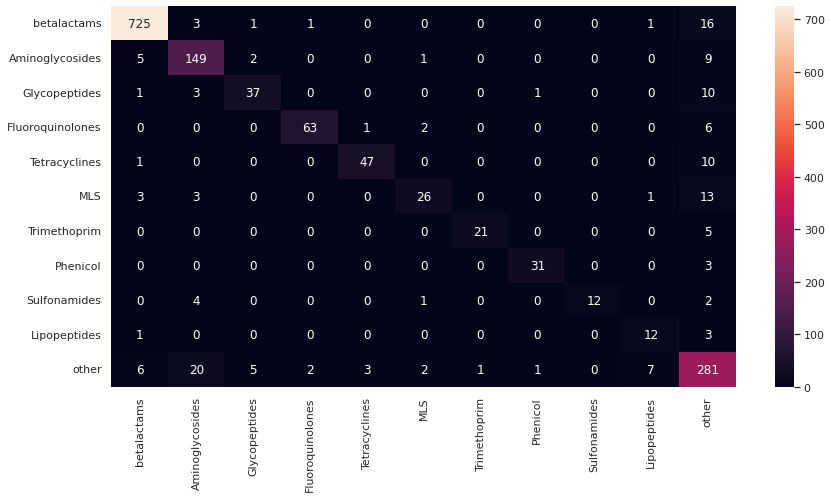

In [30]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(14,7)})

fig, ax = plt.subplots()
sns.heatmap(cmat, annot=cmat, fmt="",  ax=ax, yticklabels=(label_code_1.keys()),
            xticklabels=label_code_1.keys())
plt.show()

In [31]:
def get_avg_length_of_seq(df):
  dict_stats = {}
  for classes in label_1:
    df_temp = df[(df["class"]==classes)&(df['Sequence'].str.len()<=2000)]
    df_temp["length"] = df_temp['Sequence'].str.len()
    dict_stats[classes] = (df_temp["length"].mean(), df_temp["length"].std(), df_temp["length"].max(), df_temp["length"].min())
  return dict_stats

In [32]:
dict_stats = get_avg_length_of_seq(df)
dict_stats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


{'Aminoglycosides': (696.3031088082902, 212.82609243082857, 1551, 375),
 'Fluoroquinolones': (736.4894736842106, 287.85923476944305, 1998, 198),
 'Glycopeptides': (923.1278195488721, 305.4917573179186, 1971, 228),
 'Lipopeptides': (1497.0, 310.9440171770183, 1977, 579),
 'MLS': (914.924, 269.2891994040286, 1710, 417),
 'Phenicol': (868.9236111111111, 293.0953228043834, 1460, 492),
 'Sulfonamides': (851.5145631067961, 83.09006029104799, 1272, 585),
 'Tetracyclines': (1494.5358361774745, 430.184887273795, 1992, 312),
 'Trimethoprim': (463.3259259259259, 83.64966296330829, 606, 237),
 'betalactams': (934.7947924722866, 169.142251527775, 1998, 211)}

In [33]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense[:-2])
model_cut

Sequential(
  (0): Embedding(5, 22)
  (1): Conv1d(22, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [34]:
# model_cut = nn.Sequential(*[model.children for i in range(1)])
# model_cut
embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

        # print(x.shape)
        # Apply pooling
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        
            # validate your model on each batch here

In [35]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5066, 64), (5066,))

In [36]:
label_value = [list(label_code_1.keys())[list(label_code_1.values()).index(p)] for p in label_list]

In [37]:
len(label_list), len(label_value)

(5066, 5066)

In [38]:
df_embedding = pd.DataFrame(data = (embedding_list))
# df_embedding["label"] = np.array(label_value)
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,10.746915,14.012117,9.483670,-3.092792,-2.859973,1.475950,-10.286603,-2.052922,-4.311553,3.333334,...,-6.090371,-6.138119,2.676452,3.154145,9.824885,7.928619,9.851609,0.957867,0.979756,-10.156139
1,-5.615756,12.322203,-7.121385,-9.411956,-12.393427,-3.215230,-10.981778,-11.256993,-3.272053,-8.010668,...,-7.838812,-4.179039,-9.453879,12.359636,4.203517,-1.076081,4.393844,0.723906,-2.839467,0.046370
2,-7.542098,-1.164943,12.901723,6.716753,3.305238,-2.314892,-4.172968,-3.256890,-6.737548,4.462438,...,-1.358786,-2.941833,11.595160,0.509726,-0.026538,-8.035609,-1.379802,-9.629855,-0.194936,-7.448337
3,-2.855665,8.728015,0.576456,-6.107038,-2.993928,-4.880913,-5.497683,-8.732465,-1.624377,-2.321949,...,-3.834320,-3.325476,-5.444252,3.309011,-0.456057,-1.800025,4.963633,-1.791328,4.793063,-10.615308
4,-1.258703,6.326075,2.158898,-3.021785,-3.198411,-1.691116,-4.543203,-0.581130,-4.109493,0.100029,...,-3.765488,-3.583613,-3.640660,5.351370,0.493593,-2.442672,1.002983,-4.351628,-3.092194,-3.641502


In [39]:
fit = umap.UMAP()
# Use default parameters?

In [40]:
reduced_embedding = fit.fit_transform(df_embedding)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [41]:
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["label"] = np.array(label_value)

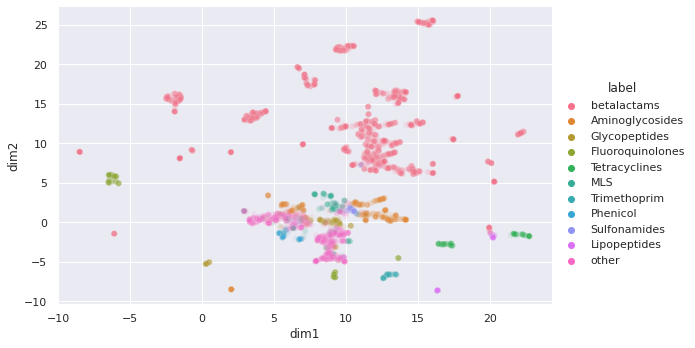

In [42]:
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='label', hue_order=label_code_1.keys(), aspect=1.61, alpha = 0.1)
plt.show()

# Multitask Learning (Joint Class and Mechanism of Antibiotic Resistance Prediction)

In [43]:
df["labels_2"] = "other"
df.loc[(df['mechanism'].str.contains("nucleotidyltransferases")),'labels_2'] = "nucleotidyltransferases"
df.loc[(df['mechanism'].str.contains("methyltransferases")),'labels_2'] = "methyltransferases"
df.loc[(df['mechanism'].str.contains("phosphotransferases")),'labels_2'] = "phosphotransferases"
df.loc[(df['mechanism'].str.contains("acetyltransferases")),'labels_2'] = "acetyltransferases"
df.loc[(df['mechanism'].str.contains("Quinolone_resistance_protein_Qnr")),'labels_2'] = "Quinolone_resistance_protein_Qnr"
df.loc[(df['mechanism'].str.contains("Dihydrofolate_reductase")),'labels_2'] = "Dihydrofolate_reductase"
df.loc[(df['mechanism'].str.contains("Tetracycline_resistance_ribosomal_protection_proteins")),
       'labels_2'] = "Tetracycline_resistance_ribosomal_protection_proteins"
df.loc[(df['mechanism'].str.contains("efflux_pump")),'labels_2'] = "efflux_pump"
df.loc[(df['mechanism'].str.contains("Fluoroquinolone-resistant_DNA_topoisomerases")),'labels_2'] = "Fluoroquinolone-resistant_DNA_topoisomerases"
df.loc[(df['mechanism'] == "Class_A_betalactamases"),'labels_2'] = "Class_A_betalactamases"
df.loc[(df['mechanism'] == "Class_B_betalactamases"),'labels_2'] = "Class_B_betalactamases"
df.loc[(df['mechanism'] == "Class_C_betalactamases"),'labels_2'] = "Class_C_betalactamases"
df.loc[(df['mechanism'] == "Class_D_betalactamases"),'labels_2'] = "Class_D_betalactamases"
label_code_2 = {}
labels_2 = ["nucleotidyltransferases", "methyltransferases", "phosphotransferases",
            "acetyltransferases", "Quinolone_resistance_protein_Qnr", "Dihydrofolate_reductase", "efflux_pump",
            "Tetracycline_resistance_ribosomal_protection_proteins", "Fluoroquinolone-resistant_DNA_topoisomerases",
            "Class_A_betalactamases", "Class_B_betalactamases", "Class_C_betalactamases","Class_D_betalactamases", "other"]
for (i, elem) in enumerate(labels_2):
  label_code_2[elem] = i

In [44]:
df.labels_2.value_counts()

other                                                    1642
Class_A_betalactamases                                   1580
Class_C_betalactamases                                    950
Class_D_betalactamases                                    900
efflux_pump                                               826
acetyltransferases                                        445
Class_B_betalactamases                                    410
nucleotidyltransferases                                   296
Quinolone_resistance_protein_Qnr                          173
methyltransferases                                        145
Dihydrofolate_reductase                                   135
Tetracycline_resistance_ribosomal_protection_proteins     134
phosphotransferases                                       122
Fluoroquinolone-resistant_DNA_topoisomerases              110
Name: labels_2, dtype: int64

In [45]:
X = df.Sequence.values
y = np.array([df.labels.values, df.labels_2.values]).transpose()
print(X.shape, y.shape)
index_to_remove = []
for (i, seq) in enumerate(X):
  if set(seq.upper())!={"A", "T", "C", "G"}:
    index_to_remove.append(i)
index_to_remove
X = np.delete(X, index_to_remove, axis=0)
y = np.delete(y, index_to_remove, axis=0)

print(X.shape,y.shape)

(7868,) (7868, 2)
(7819,) (7819, 2)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 

In [47]:
import torch.nn.functional as F

def encode_multitask(seq, label, labels_dict1, labels_dict2):
  label_int1 = labels_dict1[label[0]]
  label_int2 = labels_dict2[label[1]]
  enc_seq = [code[x] for x in seq.upper()]
  return [torch.LongTensor(enc_seq[0:2000]), torch.LongTensor([label_int1, label_int2]), len(enc_seq)]

class SequenceDatasetMultitask(Dataset):
    def __init__(self, X, y, labels_dict1, labels_dict2):
        
        self.X = X 
        self.y = y 
        self.labels_dict1 =labels_dict1
        self.labels_dict2 = labels_dict2
        self.len=len(self.X)      

    def __getitem__(self, index):
        # your implementation here: 
        X_elem, y_elem, length_seq = encode_multitask(self.X[index], self.y[index], 
                                                      labels_dict1=self.labels_dict1, labels_dict2 = self.labels_dict2)
        return F.pad(X_elem, pad=(0, 2000 - len(X_elem))), y_elem

    def __len__(self):
        return self.len
    




In [48]:
train_data = SequenceDatasetMultitask(X_train, y_train, labels_dict1 = label_code_1, labels_dict2 = label_code_2)
val_data = SequenceDatasetMultitask(X_val, y_val, labels_dict1 = label_code_1, labels_dict2 = label_code_2)
test_data = SequenceDatasetMultitask(X_test, y_test, labels_dict1 = label_code_1, labels_dict2 = label_code_2)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# fill in code here
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)# fill in code here
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)# fill in code here

In [49]:
class cnn1d_multitask(nn.Module):
    def __init__(self, label_count1 = len(label_code_1), label_count2 = len(label_code_2)):
        super(cnn1d_multitask, self).__init__()
        count = 2*(label_count1+label_count2)
        self.embedding = nn.Embedding(5, count)
        self.conv1 = nn.Conv1d(count, 64, kernel_size = 3, padding='same')
        self.maxpool1 = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool2 = nn.MaxPool1d(kernel_size=5)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool3 = nn.MaxPool1d(kernel_size=5)
        self.dense1 = nn.Sequential(nn.Linear(1024, 256), 
                             nn.ReLU(), nn.Linear(256, 64),
                             nn.ReLU(), nn.Linear(64, label_count1))
        self.dense2 = nn.Sequential(nn.Linear(1024, 256), 
                             nn.ReLU(), nn.Linear(256, 64),
                             nn.ReLU(), nn.Linear(64, label_count2))

    def forward(self, x):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.embedding(x)
        # print(x.shape)
        # Apply pooling
        x = self.conv1(x.permute(0, 2, 1))
        # print(x.shape)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = torch.flatten(x, 1)
        x1 = self.dense1(x)
        x2 = self.dense2(x)
        
        return x1, x2

In [50]:
model = cnn1d_multitask(label_count1=len(label_code_2), label_count2 = len(label_code_2))
model = model.to(device)

In [51]:
model

cnn1d_multitask(
  (embedding): Embedding(5, 56)
  (conv1): Conv1d(56, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (dense1): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=14, bias=True)
  )
  (dense2): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=14

In [52]:
def train_multitask(model, dataloader, optimizer, device):
    
    '''
    A function to train on the entire dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization 
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    batch_loss = []
    model.train() # Set model to training mode 
    train_loss = 0 
    count = 0
    for batch in dataloader:    
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        # print(seq.shape, label.shape)
        # train your model on each batch here 
        y_pred = model(seq)
        # print(label.shape, y_pred.shape)
        loss1 = nn.functional.cross_entropy(y_pred[0], label.squeeze()[:, 0])# fill in loss here
        loss2 = nn.functional.cross_entropy(y_pred[1], label.squeeze()[:, 1])
        loss = (loss1+loss2)/2
        train_loss += (loss)*len(label)
        count += len(label)
        batch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/count
    return np.array(batch_loss).mean(), train_loss.detach().cpu().numpy() 


def validate_multitask(model, dataloader, device):
    
    '''
    A function to validate on the validation dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    batch_loss = []
    val_loss = 0
    count = 0
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
        # print(label.shape, y_pred.shape)
            loss1 = nn.functional.cross_entropy(y_pred[0], label.squeeze()[:, 0])# fill in loss here
            loss2 = nn.functional.cross_entropy(y_pred[1], label.squeeze()[:, 1])
            loss = (loss1+loss2)/2
            val_loss += loss*len(label)
            count += len(label)
            batch_loss.append(loss.item())
            # validate your model on each batch here 
        val_loss = val_loss/count     
    return np.array(batch_loss).mean(), val_loss.detach().cpu().numpy()    

In [53]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.5*1e-3) 

In [54]:
label_code_2

{'Class_A_betalactamases': 9,
 'Class_B_betalactamases': 10,
 'Class_C_betalactamases': 11,
 'Class_D_betalactamases': 12,
 'Dihydrofolate_reductase': 5,
 'Fluoroquinolone-resistant_DNA_topoisomerases': 8,
 'Quinolone_resistance_protein_Qnr': 4,
 'Tetracycline_resistance_ribosomal_protection_proteins': 7,
 'acetyltransferases': 3,
 'efflux_pump': 6,
 'methyltransferases': 1,
 'nucleotidyltransferases': 0,
 'other': 13,
 'phosphotransferases': 2}

In [55]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(8):
    
    # Compute train your model on training data
    epoch_loss, train_loss = train_multitask(model, train_dataloader, optimizer,  device=device)
    
    # Validate your on validation data 
    epoch_loss , val_loss = validate_multitask(model, val_dataloader, device=device) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler records the validation loss 
    # scheduler.step(val_loss)
    
    print(epoch, train_loss, val_loss)

epoch train loss validation loss
0 1.3818611 1.1369979
1 0.9888603 0.7867269
2 0.6410331 0.52987695
3 0.4498687 0.41866633
4 0.33500975 0.3626747
5 0.24774644 0.31251377
6 0.17942639 0.30727285
7 0.12367649 0.30638865


In [58]:
pred_labels_class = []
pred_labels_mechanism = []
true_labels_class = []
true_labels_mechanism = []
test_loss = 0
with torch.no_grad():
  model.eval()
  for batch in test_dataloader:
    seq, label = batch
    seq = seq.to(device)
    label = label.to(device)
    logits = model(seq)
    loss1 = nn.functional.cross_entropy(logits[0], label.squeeze()[:, 0])# fill in loss here
    loss2 = nn.functional.cross_entropy(logits[1], label.squeeze()[:, 1])
    loss = (loss1+loss2)/2
    test_loss += loss*len(label)
    preds1 = logits[0].max(1).indices
    preds2 = logits[1].max(1).indices
    true_labels_class.extend(list(label.squeeze().detach().cpu().numpy()[:, 0]))
    true_labels_mechanism.extend(list(label.squeeze().detach().cpu().numpy()[:, 1]))

    pred_labels_class.extend(list(preds1.squeeze().detach().cpu().numpy()))
    pred_labels_mechanism.extend(list(preds2.squeeze().detach().cpu().numpy()))
test_loss = test_loss/len(test_data)
test_loss = test_loss.detach().cpu().numpy()
print("Test loss is {}".format(test_loss))
class_acc = (np.array(true_labels_class) ==  np.array(pred_labels_class)).mean()
mechanism_acc = (np.array(true_labels_mechanism) ==  np.array(pred_labels_mechanism)).mean()

print("Test Acc for Class Prediction is {}".format(class_acc))
print("Test Acc for Mechanism Prediction is {}".format(mechanism_acc))

Test loss is 0.35637062788009644
Test Acc for Class Prediction is 0.9008951406649617
Test Acc for Mechanism Prediction is 0.9117647058823529


In [ ]:
cmat = confusion_matrix(true_labels_class, pred_labels_class)

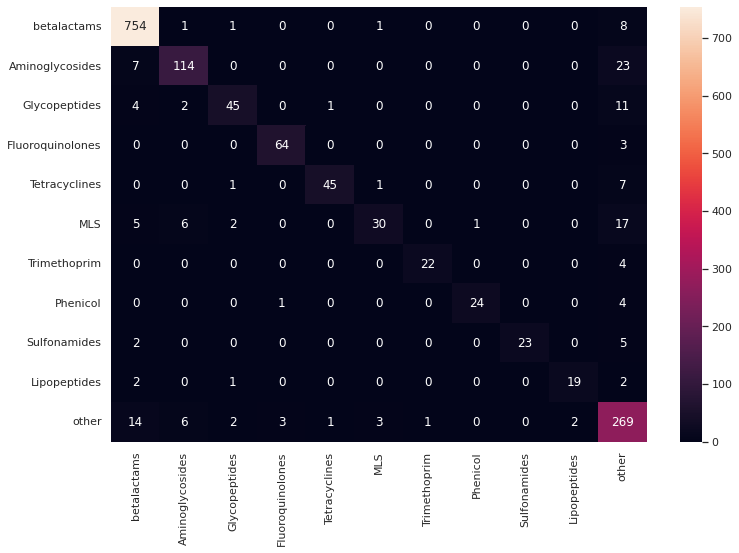

In [60]:
sns.set(rc = {'figure.figsize':(12,8)})
fig, ax = plt.subplots()
sns.heatmap(cmat, annot=cmat, fmt="",  ax=ax, yticklabels=(label_code_1.keys()),
            xticklabels=label_code_1.keys())
plt.show()

In [62]:
cmat = confusion_matrix(true_labels_mechanism, pred_labels_mechanism)

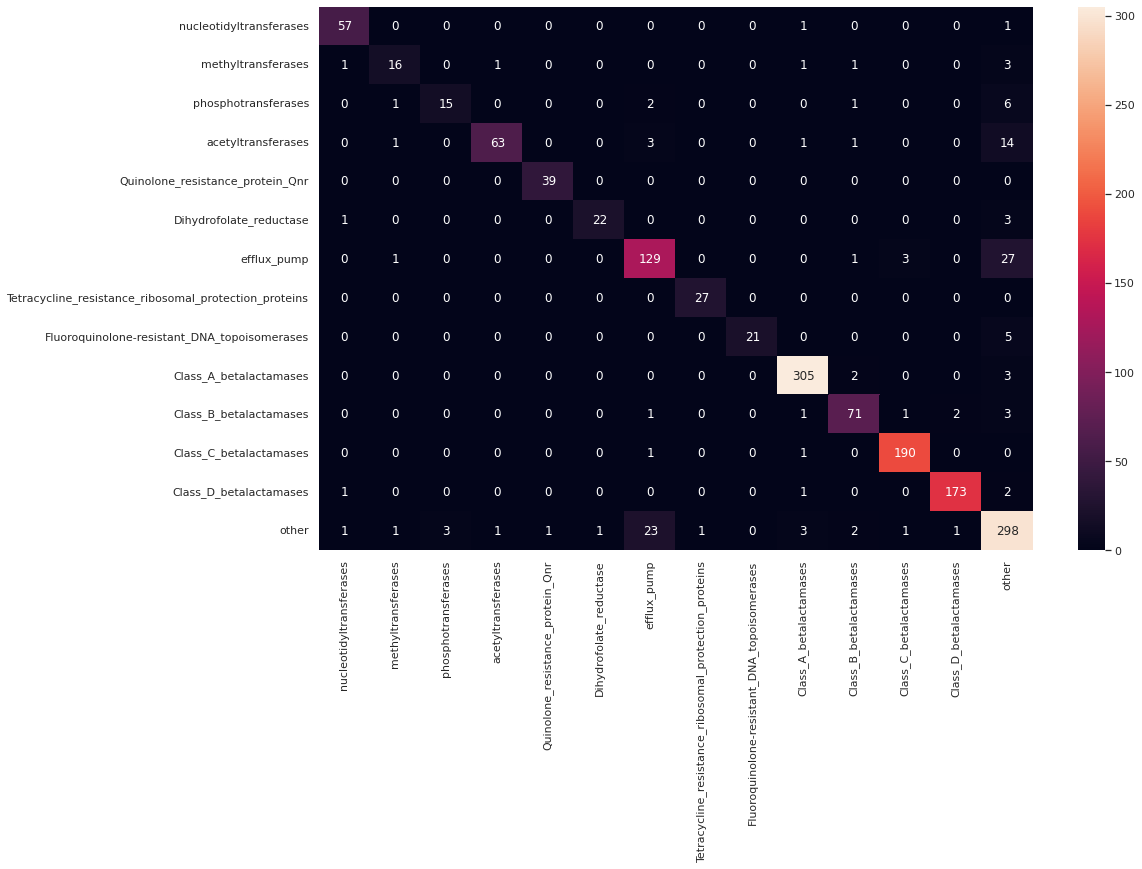

In [64]:
sns.set(rc = {'figure.figsize':(16,10)})
fig, ax = plt.subplots()
sns.heatmap(cmat, annot=cmat, fmt="",  ax=ax, yticklabels=(label_code_2.keys()),
            xticklabels=label_code_2.keys())
plt.show()

In [65]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense1[:-2])
model_cut

Sequential(
  (0): Embedding(5, 56)
  (1): Conv1d(56, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=14, bias=True)
  )
  (8): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [66]:
# model_cut = nn.Sequential(*[model.children for i in range(1)])
# model_cut
embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

        # print(x.shape)
        # Apply pooling
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        
            # validate your model on each batch here

In [67]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5066, 14), (5066, 2))

In [68]:
label_value = [list(label_code_1.keys())[list(label_code_1.values()).index(p[0])] for p in label_list]

In [69]:
df_embedding = pd.DataFrame(data = (embedding_list))
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,6.441265,-5.602183,0.065177,12.303257,-8.709270,-4.083623,-14.830733,-6.384237,-14.841390,-6.451632,0.757958,-11.372272,-8.329838,-11.274966
1,-0.620327,5.851091,1.633195,-4.070491,-0.977251,-3.425575,-10.587955,-4.073300,-6.899523,-1.037052,2.259671,-14.864726,-12.852295,-15.725842
2,13.851481,-4.759349,-1.704426,-16.550392,-0.189828,-3.741290,-15.544604,-5.036259,-1.814421,-4.222749,6.472857,-18.006388,-14.269607,-14.687235
3,-3.446860,-2.002345,1.946810,-4.364957,1.493561,1.080279,-10.520819,2.472909,-5.150030,-1.184755,2.288925,-10.773693,-12.420458,-14.854528
4,9.676913,-0.111556,-0.094469,-7.826673,-9.171335,0.795162,-12.074318,-6.588287,-4.131993,-2.149181,3.080300,-19.147699,-10.381135,-13.985065


In [70]:
fit = umap.UMAP()
reduced_embedding = fit.fit_transform(df_embedding)

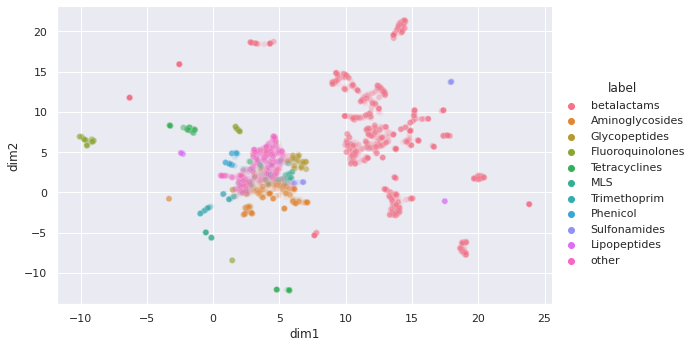

In [71]:
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["label"] = np.array(label_value)
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='label', hue_order=label_code_1.keys(), aspect=1.61, alpha = 0.1)
plt.show()

In [72]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense2[:-2])
model_cut

Sequential(
  (0): Embedding(5, 56)
  (1): Conv1d(56, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=14, bias=True)
  )
  (8): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [73]:
# model_cut = nn.Sequential(*[model.children for i in range(1)])
# model_cut
embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

        # print(x.shape)
        # Apply pooling
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        
            # validate your model on each batch here

In [74]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5066, 14), (5066, 2))

In [86]:
label_value1 = [list(label_code_1.keys())[list(label_code_1.values()).index(p[0])] for p in label_list]
label_value2 = [list(label_code_2.keys())[list(label_code_2.values()).index(p[1])] for p in label_list]

In [87]:
df_embedding = pd.DataFrame(data = (embedding_list))
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,18.188080,-3.085083,-2.828564,-17.279167,-8.715981,-6.907744,-24.984104,-6.397376,-10.770088,-1.735684,7.756109,-30.625252,-20.116386,-22.577370
1,20.916681,-3.073245,-4.726564,-15.441816,-8.616161,-7.403107,-22.669571,-7.028917,-9.443855,-4.394026,7.184781,-26.950121,-17.257484,-20.513916
2,15.297036,-1.564206,-3.260756,-12.379507,-5.785124,-5.539174,-16.126034,-5.539158,-3.949404,-4.770827,5.712156,-19.419094,-13.269413,-12.922839
3,-0.136050,3.374479,-0.286539,-11.772344,0.033794,4.946784,-8.758506,-3.213155,3.714409,-0.480174,3.307365,-14.516476,-12.076260,-13.173118
4,12.443785,-2.399482,-1.802982,-16.930210,-3.952559,-5.193727,-18.235401,-6.952277,-1.321212,-2.738615,5.339142,-19.117523,-17.359884,-14.588781


In [88]:
fit = umap.UMAP()
reduced_embedding = fit.fit_transform(df_embedding)

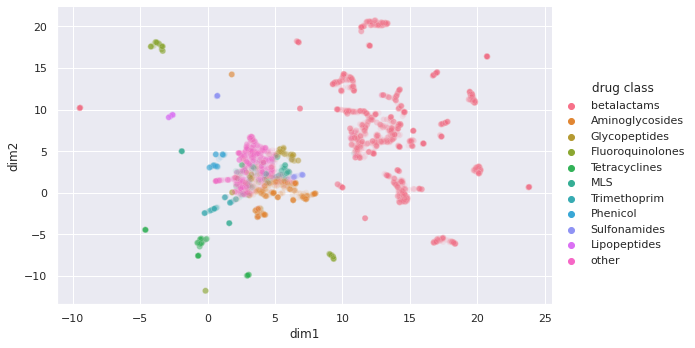

In [92]:
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["drug class"] = np.array(label_value1)
reduced_embedding["drug mechanism"] = np.array(label_value2)

sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='drug class', hue_order=label_code_1.keys(), aspect=1.61, alpha = 0.1)
plt.show()

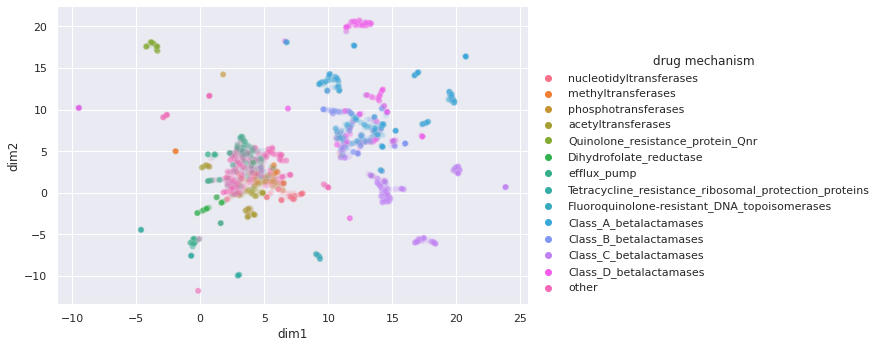

In [93]:
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='drug mechanism', hue_order=label_code_2.keys(), aspect=1.61, alpha = 0.1)
plt.show()

0.3516776817488561


(array([2.070e+02, 9.060e+02, 3.597e+03, 1.261e+03, 8.920e+02, 2.910e+02,
        2.010e+02, 1.240e+02, 6.600e+01, 9.300e+01, 3.200e+01, 1.270e+02,
        1.100e+01, 3.100e+01, 1.000e+00, 2.300e+01, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 121. ,  379.8,  638.6,  897.4, 1156.2, 1415. , 1673.8, 1932.6,
        2191.4, 2450.2, 2709. , 2967.8, 3226.6, 3485.4, 3744.2, 4003. ,
        4261.8, 4520.6, 4779.4, 5038.2, 5297. ]),
 <a list of 20 Patch objects>)

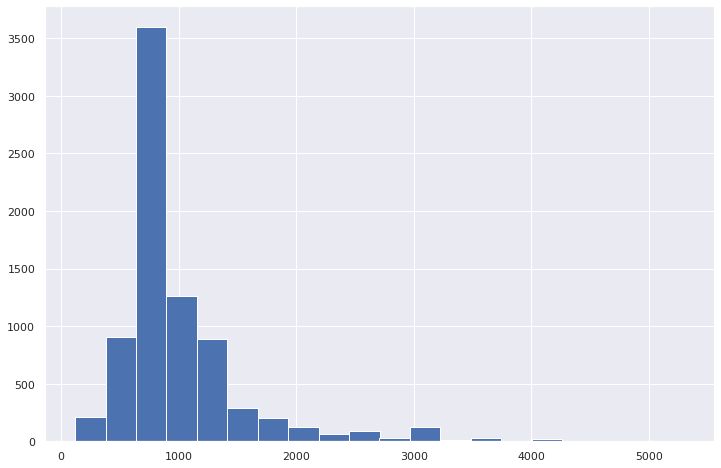

In [ ]:
seq_len = np.array([len(m) for m in df.Sequence.values])
print((seq_len>1000).mean())
plt.hist(seq_len, bins = 20)

In [ ]:

# Create dataloaders

In [ ]:
# Create model

In [ ]:
# Train model

In [ ]:
# Test model